<a href="https://colab.research.google.com/github/jhk0429/Segmentation_project/blob/main/PSPNet/Inference_incep_psp_newdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = 'drive/MyDrive/Colab Notebooks/Inceptionv3_PSPNet_newdata_0927'

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.6.0


In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [6]:
mask = imread('images/test/gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


In [7]:
import glob
import cv2
train_x = []
train_y = []

for img in glob.glob("images/test/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576))
    #n = tf.expand_dims(n,-1)
    #n = tf.image.grayscale_to_rgb(n)
    train_x.append(n)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    y = imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576))

    train_y.append(bbb)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)

(25, 480, 576, 3)
(25, 480, 576, 1)


In [8]:
sample_image = test_x[0]
sample_mask = test_y[0]

In [5]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [9]:
model = tf.keras.models.load_model(path)

In testing Mode...


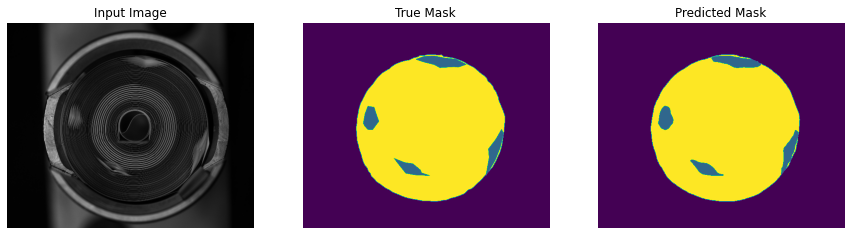

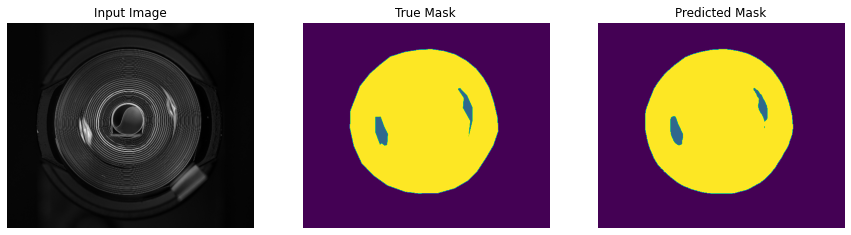

In [10]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=2)

In [11]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tqdm import tqdm
import time

In [12]:
# Load converted model and infer
model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [15]:
time_list = []
pred_mask = []

for image in tqdm(test_x):
  start = time.time()
  image = tf.expand_dims(image,0)
  pred_mask.append(frozen_func(image)) # N, H, W, 3
  time_list.append(time.time()-start)

100%|██████████| 25/25 [00:00<00:00, 40.57it/s]


In [16]:
print("Average inference time is: ",np.mean(time_list) * 1000, "ms")
print(time_list)

Average inference time is:  23.951292037963867 ms
[0.009415388107299805, 0.0043828487396240234, 0.004795551300048828, 0.004353761672973633, 0.004689455032348633, 0.004179954528808594, 0.004639148712158203, 0.013398408889770508, 0.03215956687927246, 0.032277822494506836, 0.030485153198242188, 0.031968116760253906, 0.0319974422454834, 0.03176236152648926, 0.03208661079406738, 0.031813859939575195, 0.03194308280944824, 0.03536105155944824, 0.03006458282470703, 0.02944040298461914, 0.03335237503051758, 0.033600807189941406, 0.03382396697998047, 0.033556222915649414, 0.033234357833862305]


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [17]:
!nvidia-smi

Mon Sep 27 06:33:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   5876MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
print(np.shape(pred_mask[0][0][0]))

(480, 576, 4)


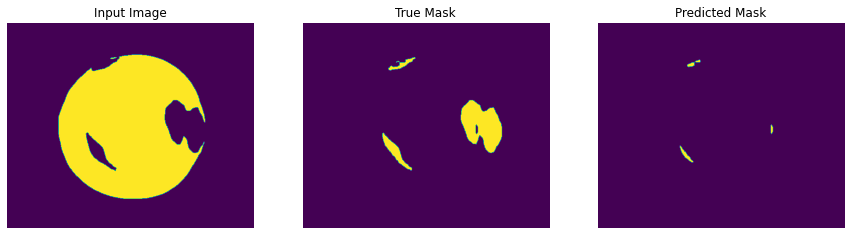

In [39]:
ex = pred_mask[9][0][0]
pushed = np.round(tf.expand_dims(ex[:,:,1], -1))
circle = np.round(tf.expand_dims(ex[:,:,3], -1))
stamped = np.round(tf.expand_dims(ex[:,:,2], -1))

display([circle,pushed,stamped])


#display([tf.expand_dims(ex[:,:,1], -1), tf.expand_dims(ex[:,:,3], -1), tf.expand_dims(ex[:,:,2], -1)])

In [1]:
detector = cv2.SimpleBlobDetector()

# Detect blobs.
keypoints = detector.detect(pushed)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(pushed, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show keypoints
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)


NameError: ignored